<a href="https://colab.research.google.com/github/sumukshashidhar/toreda/blob/master/src/ai-backend/Stock_Returns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-beta1

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
2.2.0-rc3


In [0]:
# More imports
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
plt.style.use('seaborn-poster')

In [0]:
# yes, you can read dataframes from URLs!
df = pd.read_csv('ITC.csv')

In [0]:
#for i in 

In [0]:
df.head()

,Unnamed: 0,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
0,0,09-Apr-2010,EQ,267.80,270.50,265.70,267.75,268.50,269.25,268.64,272.9,177.5,2800852,"752,423,958.40",NaN
1,1,08-Apr-2010,EQ,268.00,268.95,266.35,269.45,266.70,267.75,267.77,272.9,177.5,2086042,"558,576,804.60",NaN
2,2,07-Apr-2010,EQ,265.35,270.00,263.50,266.25,269.45,269.45,266.22,272.9,177.5,2910180,"774,754,436.65",NaN
3,3,06-Apr-2010,EQ,264.80,267.60,263.10,264.80,266.25,266.25,264.99,272.9,177.5,3224970,"854,593,065.00",NaN
4,4,05-Apr-2010,EQ,267.70,268.70,264.10,264.00,264.40,264.80,265.43,272.9,177.5,2445140,"649,016,104.60",NaN


In [0]:
df.tail()

,Unnamed: 0,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
2965,2965,17-Apr-2018,EQ,265.4,268.40,262.7,264.45,267.00,267.60,265.28,367.7,250.0,13207767,"3,503,727,423.40",83815.0
2966,2966,16-Apr-2018,EQ,260.5,264.90,260.0,260.75,264.35,264.45,263.60,367.7,250.0,5212182,"1,373,910,540.00",110574.0
2967,2967,13-Apr-2018,EQ,263.0,263.50,260.0,261.95,260.50,260.75,261.59,367.7,250.0,4991314,"1,305,660,006.00",42992.0
2968,2968,12-Apr-2018,EQ,265.1,265.15,261.4,265.15,262.15,261.95,262.57,367.7,250.0,6125006,"1,608,254,077.75",61995.0
2969,2969,11-Apr-2018,EQ,266.9,267.55,263.4,266.70,265.30,265.15,264.95,367.7,250.0,5232228,"1,386,296,172.25",57667.0


In [0]:
print(df.columns)

Index(['Unnamed: 0', 'Date ', 'series ', 'OPEN ', 'HIGH ', 'LOW ',
       'PREV. CLOSE ', 'ltp ', 'close ', 'vwap ', '52W H ', '52W L ',
       'VOLUME ', 'VALUE ', 'No of trades '],
      dtype='object')


In [0]:
# Start by doing the WRONG thing - trying to predict the price itself
series = df['close '].values.reshape(-1, 1)

In [0]:
# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [0]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 2000
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (970, 2000, 1) Y.shape (970,)


In [0]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.1),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
16/16 [==============================] - 2s 107ms/step - loss: 0.2004 - val_loss: 0.0642
Epoch 2/80
16/16 [==============================] - 1s 83ms/step - loss: 0.0515 - val_loss: 0.0431
Epoch 3/80
16/16 [==============================] - 1s 83ms/step - loss: 0.0392 - val_loss: 0.0244
Epoch 4/80
16/16 [==============================] - 1s 81ms/step - loss: 0.0329 - val_loss: 0.0142
Epoch 5/80
16/16 [==============================] - 1s 84ms/step - loss: 0.0299 - val_loss: 0.0171
Epoch 6/80
16/16 [==============================] - 1s 84ms/step - loss: 0.0271 - val_loss: 0.0163
Epoch 7/80
16/16 [==============================] - 1s 82ms/step - loss: 0.0289 - val_loss: 0.0291
Epoch 8/80
16/16 [==============================] - 1s 84ms/step - loss: 0.0322 - val_loss: 0.0162
Epoch 9/80
16/16 [==============================] - 1s 85ms/step - loss: 0.0291 - val_loss: 0.0155
Epoch 10/80
16/16 [==============================] - 1s 84ms/step - loss: 0.0283 - val_loss: 0.0120
Epoch 11

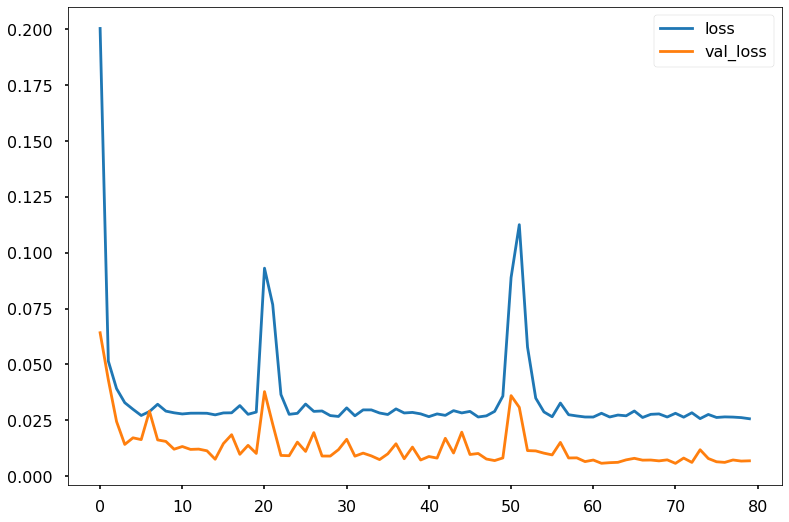

In [0]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(970, 1)


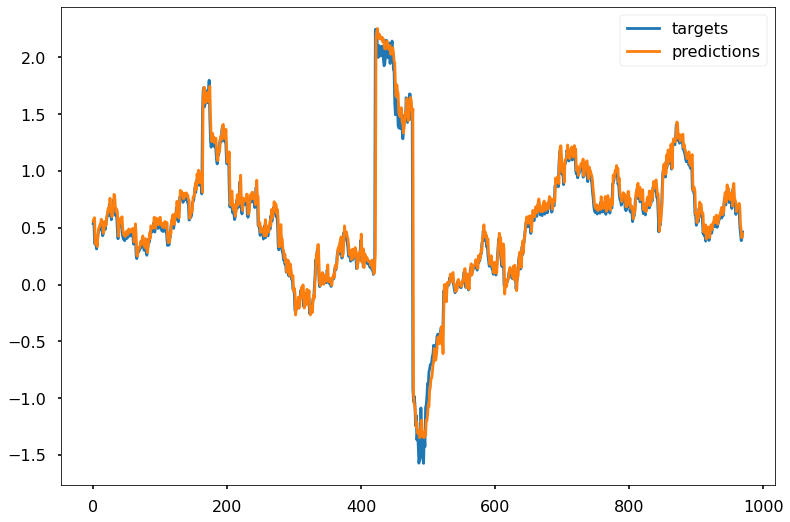

In [0]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

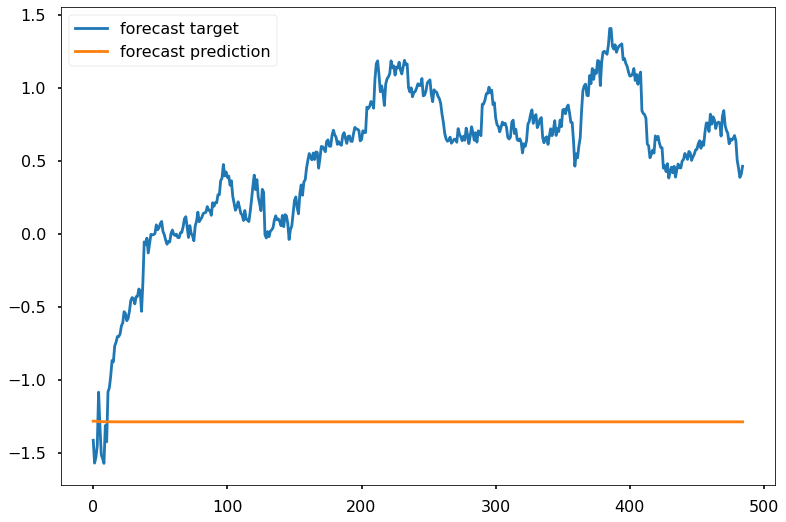

In [0]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [0]:
# calculate returns by first shifting the data
df['PREV. CLOSE'] = df['close '].shift(1) # move everything up 1

# so now it's like
# close / prev close
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]
# ...
# x[t] x[t-1]

In [0]:
df.head()

,Unnamed: 0,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades,PREV. CLOSE
0,0,09-Apr-2010,EQ,267.80,270.50,265.70,267.75,268.50,269.25,268.64,272.9,177.5,2800852,"752,423,958.40",NaN,NaN
1,1,08-Apr-2010,EQ,268.00,268.95,266.35,269.45,266.70,267.75,267.77,272.9,177.5,2086042,"558,576,804.60",NaN,269.25
2,2,07-Apr-2010,EQ,265.35,270.00,263.50,266.25,269.45,269.45,266.22,272.9,177.5,2910180,"774,754,436.65",NaN,267.75
3,3,06-Apr-2010,EQ,264.80,267.60,263.10,264.80,266.25,266.25,264.99,272.9,177.5,3224970,"854,593,065.00",NaN,269.45
4,4,05-Apr-2010,EQ,267.70,268.70,264.10,264.00,264.40,264.80,265.43,272.9,177.5,2445140,"649,016,104.60",NaN,266.25


In [0]:
# then the return is
# (x[t] - x[t-1]) / x[t-1]
df['Return'] = (df['close '] - df['PREV. CLOSE']) / df['PREV. CLOSE']

In [0]:
df.head()

,Unnamed: 0,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades,PREV. CLOSE,Return
0,0,09-Apr-2010,EQ,267.80,270.50,265.70,267.75,268.50,269.25,268.64,272.9,177.5,2800852,"752,423,958.40",NaN,NaN,NaN
1,1,08-Apr-2010,EQ,268.00,268.95,266.35,269.45,266.70,267.75,267.77,272.9,177.5,2086042,"558,576,804.60",NaN,269.25,-0.005571
2,2,07-Apr-2010,EQ,265.35,270.00,263.50,266.25,269.45,269.45,266.22,272.9,177.5,2910180,"774,754,436.65",NaN,267.75,0.006349
3,3,06-Apr-2010,EQ,264.80,267.60,263.10,264.80,266.25,266.25,264.99,272.9,177.5,3224970,"854,593,065.00",NaN,269.45,-0.011876
4,4,05-Apr-2010,EQ,267.70,268.70,264.10,264.00,264.40,264.80,265.43,272.9,177.5,2445140,"649,016,104.60",NaN,266.25,-0.005446


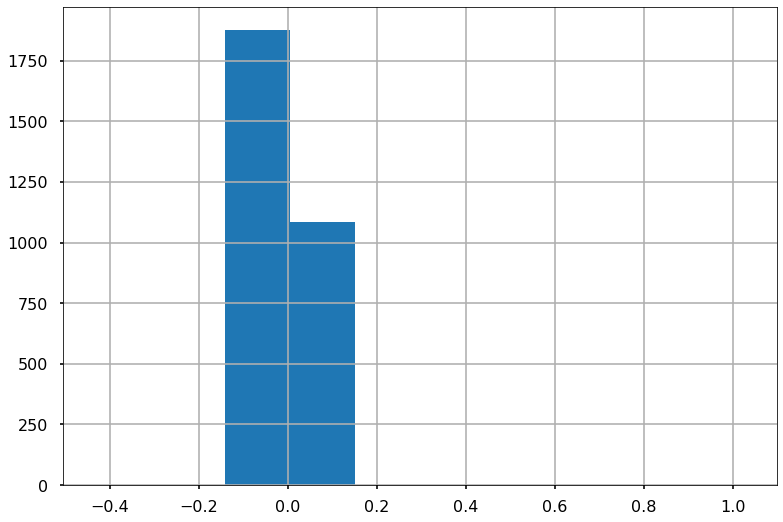

In [0]:
# Now let's try an LSTM to predict returns
df['Return'].hist()

In [0]:
series = df['Return'].values[1:].reshape(-1, 1)

# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [0]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2959, 10, 1) Y.shape (2959,)


In [0]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.01),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
47/47 [==============================] - 1s 11ms/step - loss: 0.9945 - val_loss: 0.6520
Epoch 2/80
47/47 [==============================] - 0s 5ms/step - loss: 0.9946 - val_loss: 0.6523
Epoch 3/80
47/47 [==============================] - 0s 5ms/step - loss: 0.9961 - val_loss: 0.6510
Epoch 4/80
47/47 [==============================] - 0s 5ms/step - loss: 0.9865 - val_loss: 0.6512
Epoch 5/80
47/47 [==============================] - 0s 5ms/step - loss: 0.9917 - val_loss: 0.6540
Epoch 6/80
47/47 [==============================] - 0s 5ms/step - loss: 0.9887 - val_loss: 0.6519
Epoch 7/80
47/47 [==============================] - 0s 5ms/step - loss: 0.9876 - val_loss: 0.6520
Epoch 8/80
47/47 [==============================] - 0s 5ms/step - loss: 0.9886 - val_loss: 0.6524
Epoch 9/80
47/47 [==============================] - 0s 5ms/step - loss: 0.9862 - val_loss: 0.6528
Epoch 10/80
47/47 [==============================] - 0s 5ms/step - loss: 0.9946 - val_loss: 0.6527
Epoch 11/80
47/47 

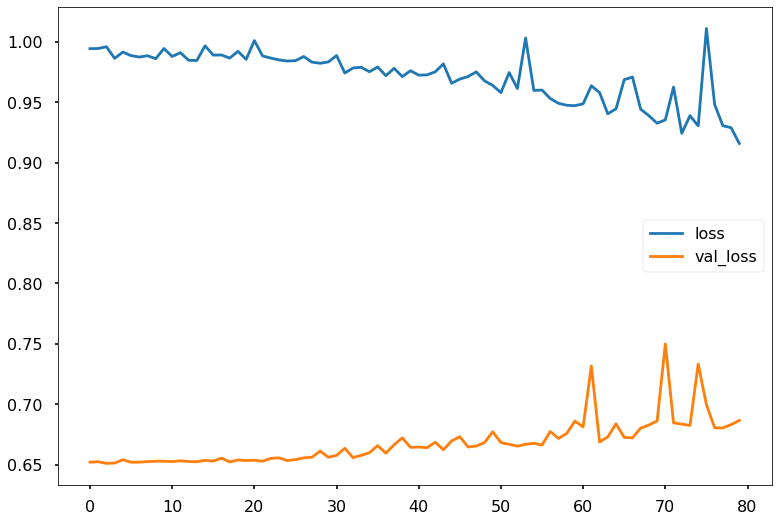

In [0]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(2959, 1)


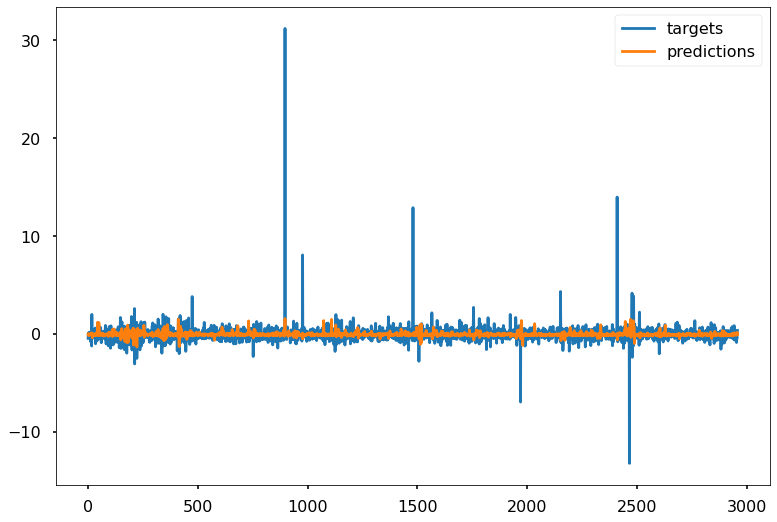

In [0]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

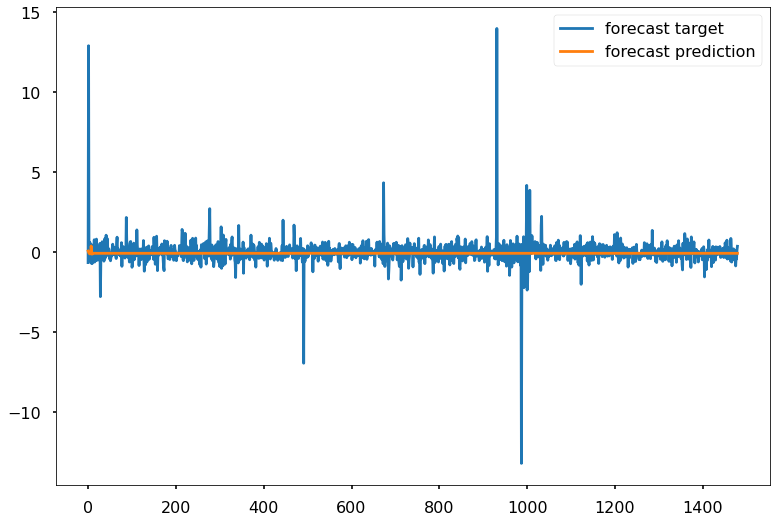

In [0]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [0]:
# Now turn the full data into numpy arrays

# Not yet in the final "X" format!
input_data = df[['OPEN ', 'HIGH ', 'LOW ', 'close ', 'VOLUME ']].values
targets = df['Return'].values

In [0]:
# Now make the actual data which will go into the neural network
T = 10 # the number of time steps to look at to make a prediction for the next day
D = input_data.shape[1]
N = len(input_data) - T # (e.g. if T=10 and you have 11 data points then you'd only have 1 sample)

In [0]:
# normalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [0]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [0]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
  # u counts from 0...(N - Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [0]:
# make the RNN
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.001),
  metrics=['accuracy'],
)

In [0]:
# train the RNN
r = model.fit(
  X_train, Y_train,
  batch_size=32,
  epochs=1000, ##CHANGE BACK TO 300 OR LESS
  validation_data=(X_test, Y_test),
)

Epoch 1/1000
62/62 [==============================] - 1s 10ms/step - loss: 0.6929 - accuracy: 0.5182 - val_loss: 0.6939 - val_accuracy: 0.4888
Epoch 2/1000
62/62 [==============================] - 0s 5ms/step - loss: 0.6895 - accuracy: 0.5348 - val_loss: 0.6929 - val_accuracy: 0.5061
Epoch 3/1000
62/62 [==============================] - 0s 5ms/step - loss: 0.6887 - accuracy: 0.5288 - val_loss: 0.6927 - val_accuracy: 0.5184
Epoch 4/1000
62/62 [==============================] - 0s 5ms/step - loss: 0.6902 - accuracy: 0.5318 - val_loss: 0.6930 - val_accuracy: 0.5092
Epoch 5/1000
62/62 [==============================] - 0s 5ms/step - loss: 0.6872 - accuracy: 0.5525 - val_loss: 0.6922 - val_accuracy: 0.5173
Epoch 6/1000
62/62 [==============================] - 0s 5ms/step - loss: 0.6868 - accuracy: 0.5455 - val_loss: 0.6928 - val_accuracy: 0.5163
Epoch 7/1000
62/62 [==============================] - 0s 5ms/step - loss: 0.6858 - accuracy: 0.5515 - val_loss: 0.6932 - val_accuracy: 0.5133
Epoch

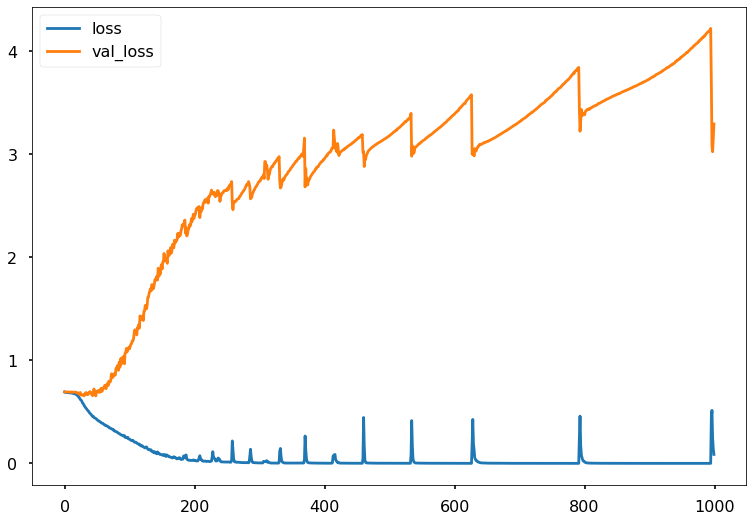

In [0]:
# plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

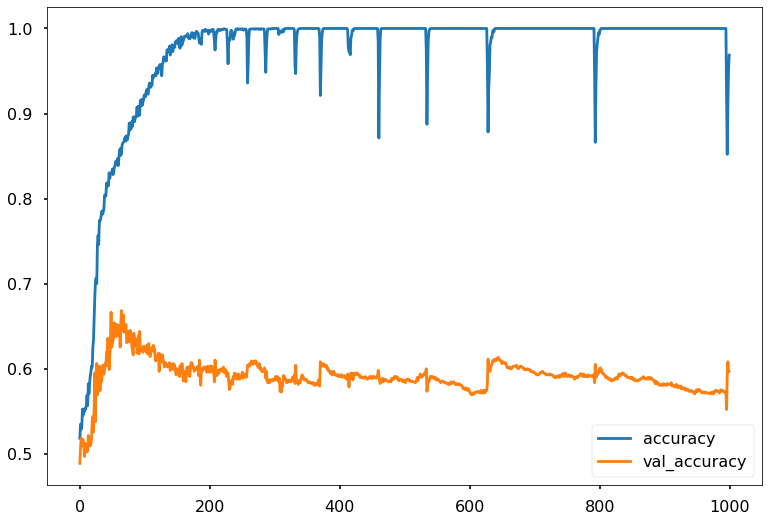

In [0]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()